In [16]:
# 【parameters.py】
class par:
    scale = 1
    T = 200
    t_back = -20
    t_fore = 20

    pixel_x = 28
    m = pixel_x*pixel_x # neurons number in 1th layer
    n =  10  # neurons number in 2th layer
    Prest = 0 # resting membrane potential
    Pmin = -500*scale
    # Pth = 5
    # D = 0.7
    
    w_max = 1.5*scale  # parameters of devices
    w_min = -0.67*scale  # parameters of devices    
    A_plus = 0.28  # parameters of devices
    A_minus = 0.30  # parameters of devices
    tau_plus = 1.18  # parameters of devices
    tau_minus = 1.19  # parametrs of devices

    epoch = 15
    sigma = 0.1 #0.02
    fr_bits = 12
    int_bits = 12

In [6]:
# 【neuron.py】Initialize all the parameters and check spikes and apply inhibitation
import numpy as np
import random
from matplotlib import pyplot as plt

class neuron:
    def __init__(self): 
        self.t_ref = 30
        self.t_rest = -1
        self.P = par.Prest 
    def check(self):
        if self.P>= self.Pth:
            self.P = par.Prest
            return 1
        elif self.P < par.Pmin:
            self.P  = par.Prest
            return 0
        else:
            return 0
    def inhibit(self):
        self.P  = par.Pmin
    def initial(self, th):
        self.Pth = th
        self.t_rest = -1
        self.P = par.Prest

In [7]:
# 【recep_field.py】Concolution kernel, preprocess the image
#import numpy as np
import cv2

def rf(inp):
    sca1 =  0.625
    sca2 =  0.125
    sca3 = -0.125
    sca4 = -.5

    # receptive field kernel
    w = [[sca4 ,sca3 , sca2 ,sca3 ,sca4],
         [sca3 ,sca2 , sca1 ,sca2 ,sca3],
         [sca2 ,sca1 ,    1 ,sca1 ,sca2],
         [sca3 ,sca2 , sca1 ,sca2 ,sca3],
         [sca4 ,sca3 , sca2 ,sca3 ,sca4]]

    pot = np.zeros([par.pixel_x,par.pixel_x])
    ran = [-2,-1,0,1,2]
    ox = 2
    oy = 2

    # convolution
    for i in range(par.pixel_x):
        for j in range(par.pixel_x):
            summ = 0
            for m in ran:
                for n in ran:
                    if (i+m)>=0 and (i+m)<=par.pixel_x-1 and (j+n)>=0 and (j+n)<=par.pixel_x-1:
                        summ = summ + w[ox+m][oy+n]*inp[i+m][j+n]/255
            pot[i][j] = summ
    return pot

In [8]:
# 【rl.py】STDP curve and weights update

# STDP 
def rl(t):
    if t>0:
        return -par.A_plus*np.exp(-float(t)/par.tau_plus)
    if t<=0:
        return par.A_minus*np.exp(float(t)/par.tau_minus)

# Update
def update(w, del_w):
    if del_w<0:
        return w + par.sigma*del_w*(w-abs(par.w_min))*par.scale
    elif del_w>0:
        return w + par.sigma*del_w*(par.w_max-w)*par.scale

In [9]:
# 【reconstruct.py】Synapses visualization
from numpy import interp

def reconst_weights(weights, num):
    weights = np.array(weights)
    weights = np.reshape(weights, (par.pixel_x,par.pixel_x))
    img = np.zeros((par.pixel_x,par.pixel_x))
    for i in range(par.pixel_x):
        for j in range(par.pixel_x):
            img[i][j] = int(interp(weights[i][j], [par.w_min,par.w_max], [0,255]))

    cv2.imwrite('neuron' + str(num) + '.png' ,img)
    return img

In [10]:
# 【spike_train.py】Generates rate based spike train from the potential map）.

import math

def encode(pot):

    train = []

    for l in range(par.pixel_x):
        for m in range(par.pixel_x):

            temp = np.zeros([(par.T+1),])

            # proportional
            freq = interp(pot[l][m], [-1.069,2.781], [1,20])

            # print freq
            if freq<=0:
                print(error)

            freq1 = math.ceil(600/freq)
            k = freq1
            if(pot[l][m]>0):
                while k<(par.T+1):
                    temp[k] = 1
                    k = k + freq1
            train.append(temp)
            # print sum(temp)
    return train

In [11]:
# 【var_th.py】Adaptive threshold

import os
from PIL import Image

def threshold(train):
    tu = np.shape(train[0])[0] # tu = 201
    thresh = 0
    for i in range(tu):
        simul_active = sum(train[:,i])
        if simul_active>thresh:
            thresh = simul_active

    return (thresh/3)*par.scale

1    0
winner is 8
2    0
winner is 4
3    0
winner is 9
4    0
winner is 6
5    0
winner is 3
6    0
winner is 1
7    0
winner is 0
8    0
winner is 6
9    0
winner is 2
10    0
winner is 6
1    1
winner is 8
2    1
winner is 4
3    1
winner is 9
4    1
winner is 7
5    1
winner is 3
6    1
winner is 1
7    1
winner is 0
8    1
winner is 2
9    1
winner is 2
10    1
winner is 6
1    2
winner is 8
2    2
winner is 4
3    2
winner is 9
4    2
winner is 7
5    2
winner is 3
6    2
winner is 1
7    2
winner is 0
8    2
winner is 5
9    2
winner is 2
10    2
winner is 6
1    3
winner is 8
2    3
winner is 4
3    3
winner is 9
4    3
winner is 7
5    3
winner is 3
6    3
winner is 1
7    3
winner is 0
8    3
winner is 5
9    3
winner is 2
10    3
winner is 6
1    4
winner is 8
2    4
winner is 4
3    4
winner is 9
4    4
winner is 7
5    4
winner is 3
6    4
winner is 1
7    4
winner is 0
8    4
winner is 5
9    4
winner is 2
10    4
winner is 6
1    5
winner is 8
2    5
winner is 4
3    5


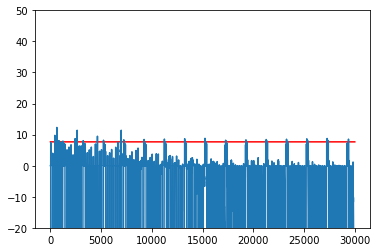

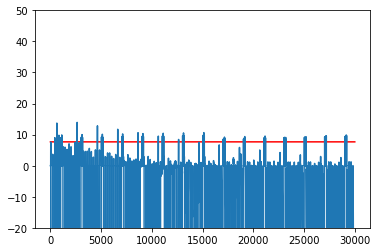

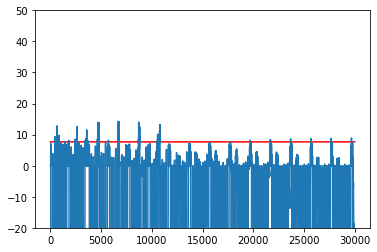

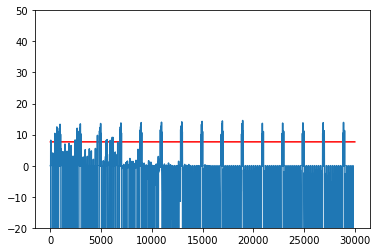

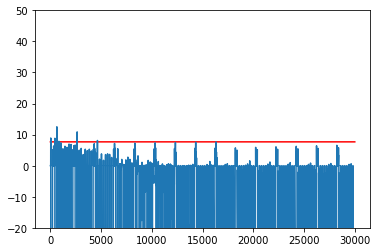

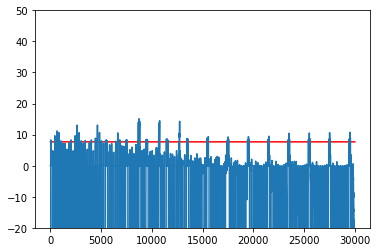

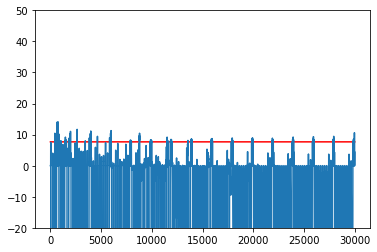

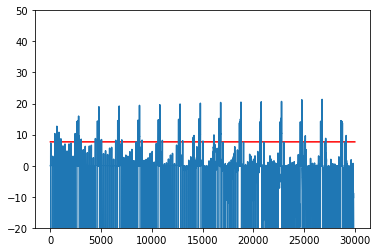

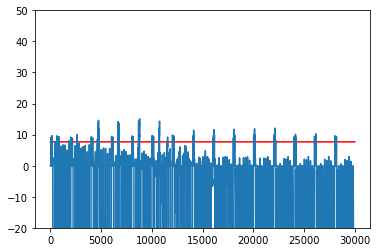

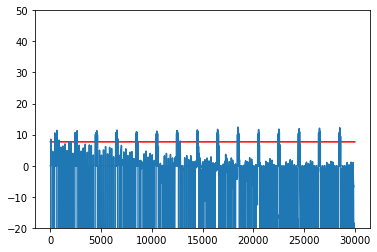

In [17]:
# 【learning.py】Training!
from numpy import interp

# potential of output neurons
pot_arrays = []
for i in range(par.n):
    pot_arrays.append([])

time  = np.arange(1, par.T+1, 1)

layer2 = []

# hidden layer
for i in range(par.n):
    a = neuron()
    layer2.append(a)

synapse = np.zeros((par.n,par.m))
for i in range(par.n):
    for j in range(par.m):
        synapse[i][j] = random.uniform(0,0.4*par.scale)

for k in range(par.epoch):
    for i in range(1,11):
        print(i,"  ",k)
        img = cv2.imread("data/" + str(i) + ".png", 0)

        pot = rf(img)

        train = np.array(encode(pot))

        var_threshold = threshold(train)

        var_D = 0.15*par.scale

        for x in layer2:
            x.initial(var_threshold)

        # sign of lateral inhibition
        f_spike = 0

        img_win = 100

        active_pot = []
        for index1 in range(par.n):
            active_pot.append(0)

        # Leaky integrate and fire neuron dynamics
        for t in time: # t = 1~200
            for j, x in enumerate(layer2): 
                active = []
                if(x.t_rest<t):
                    x.P = x.P + np.dot(synapse[j], train[:,t])
                    if(x.P>par.Prest):
                        x.P -= var_D
                    active_pot[j] = x.P

                pot_arrays[j].append(x.P)

            # Lateral Inhibition
            if(f_spike==0):
                high_pot = max(active_pot)
                if(high_pot>var_threshold):
                    f_spike = 1
                    winner = np.argmax(active_pot)
                    img_win = winner
                    print("winner is " + str(winner))
                    for s in range(par.n):
                        if(s!=winner):
                            layer2[s].P = par.Pmin

            # check sipkes and update weights
            for j,x in enumerate(layer2):
                s = x.check()
                if(s==1):
                    x.t_rest = t + x.t_ref
                    x.P = par.Prest
                    for h in range(par.m):
                        for t1 in range(-2,par.t_back-1, -1):
                            if 0<=t+t1<par.T+1:
                                if train[h][t+t1] == 1:
                                    # print "weight change by" + str(update(synapse[j][h], rl(t1)))
                                    synapse[j][h] = update(synapse[j][h], rl(t1))
                        '''
                        for t1 in range(2,par.t_fore+1, 1):
                            if 0<=t+t1<par.T+1:
                                if train[h][t+t1] == 1:
                                    # print "weight change by" + str(update(synapse[j][h], rl(t1)))
                                    synapse[j][h] = update(synapse[j][h], rl(t1))
                        '''
                        
        if(img_win!=100):
            for p in range(par.m):
                if sum(train[p])==0:
                    synapse[img_win][p] -= 0.06*par.scale
                    if(synapse[img_win][p]<par.w_min):
                        synapse[img_win][p] = par.w_min

ttt = np.arange(0,len(pot_arrays[0]),1) 
Pth = []
for i in range(len(ttt)):
    Pth.append(layer2[0].Pth)

# plotting
for i in range(par.n):
    axes = plt.gca()
    axes.set_ylim([-20,50])
    plt.plot(ttt,Pth, 'r' )
    plt.plot(ttt,pot_arrays[i])
    plt.show()

# Reconstructing weights
for i in range(par.n):
    reconst_weights(synapse[i],i+1)